In [641]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [39]:
stores = pd.read_csv('stores.csv')
items = pd.read_csv('items.csv')
transactions = pd.read_csv('transactions.csv')
oil = pd.read_csv('oil.csv')
holidays = pd.read_csv('holidays_events.csv')

In [ ]:
dtypes = {'store_nbr': np.dtype('int64'),
          'item_nbr': np.dtype('int64'),
          'unit_sales': np.dtype('float64'),
          'onpromotion': np.dtype('O')}

train_data = pd.read_csv('train.csv', dtype=dtypes)

In [ ]:
test_data = pd.read_csv('test.csv',dtype=dtypes)

In [ ]:
train_data.head()
train_data.shape
train_data.dtypes
train_data.describe()

In [ ]:
test_data.head()
test_data.shape
test_data.dtypes

## Oil Dataset

In [81]:
oil.shape

(1218, 2)

In [82]:
oil.dtypes

date           object
dcoilwtico    float64
dtype: object

`dcoilwtico` : refers to the price of the oil on a particular `date`

In [79]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [80]:
oil.tail()

,date,dcoilwtico
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96
1217,2017-08-31,47.26


In [56]:
oil.describe()

,dcoilwtico
count,1175.000000
mean,67.714366
std,25.630476
min,26.190000
25%,46.405000
50%,53.190000
75%,95.660000
max,110.620000


In [58]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [74]:
#check for which columns have null values. 
null_col = oil.columns[oil.isnull().any()]
#total number of null values in each column
oil[null_col].isnull().sum()

dcoilwtico    43
dtype: int64

The `dcoilwtico` column has 43 null values. 

In [85]:
#rename price column to something more understandable
oil = oil.rename(columns={"dcoilwtico":"oil_price"})

Rename the `dcoilwtico` column to a more intuitive name `oil_price`.

In [151]:
start_date = min(train_data.date) #get start date of data in training set 
end_date = max(train_data.date)   #get end date of data in training set

In [181]:
# convert date from string to datetime type
min_date = datetime.strptime(start_date, '%Y-%m-%d')  #start date
max_date = datetime.strptime(end_date, '%Y-%m-%d')  # end date
delta =max_date-min_date #get total number of days in between start and end dates
delta.days
all_dates = [] #to store all dates between the start and end dates of training set.
for i in range(delta.days + 1):
    all_dates.append(datetime.strftime(d1 + timedelta(days=i), '%Y-%m-%d'))
# convert list into an array
all_dates = pd.DataFrame({'date':all_dates})

In [642]:
#
oil_merged = all_dates.merge(oil, left_on='date',right_on='date',how='left')

In [185]:
len(oil_merged)

1688

In [186]:
#check for which columns have null values. 
null_col = oil_merged.columns[oil_merged.isnull().any()]
#total number of null values in each column
oil_merged[null_col].isnull().sum()

oil_price    525
dtype: int64

After adding the extra dates from the training set, there are 525 null values

In [644]:
#Extract all indexes which contain null values.
na_index_oil = oil_merged[oil_merged['oil_price'].isnull() == True].index.values

#Define lists to hold the previous and next indexes for each index that contains null value. 
na_index_oil_previous = np.maximum(0, na_index_oil-1)
na_index_oil_next = na_index_oil.copy()

#Check if the values following a null value are also null. If so, then find the next non-null value and store it in element in the na_index_oil_next list. 
for i in range(len(na_index_oil)):
    j = 1
    while (na_index_oil[min(i+j,len(na_index_oil)-1)] == na_index_oil[i]+j):
        j += 1
    na_index_oil_next[i] = min(len(oil)-1, na_index_oil_next[i] + j )
    
#If the first row in the oil_price column has a na value, then fill that na value with the next row's  value.
#Else if the last row in the oil_price column has a na value, then fill that na value with the previous row's  value.
#Else fill the na value with the average of the previous and next values. 
for i in range(len(na_index_oil)):
    if (na_index_oil[i] == 0):
        oil_merged.loc[na_index_oil[i], 'oil_price'] = oil_merged.loc[na_index_oil_next[i], 'oil_price']
    elif (na_index_oil[i] == len(oil)):
        oil_merged.loc[na_index_oil[i], 'oil_price'] = oil_merged.loc[na_index_oil_previous[i], 'oil_price']
    else:
        oil_merged.loc[na_index_oil[i], 'oil_price'] = (oil_merged.loc[na_index_oil_next[i], 'oil_price'] + oil_merged.loc[na_index_oil_previous[i], 'oil_price'])/ 2   

In [645]:
#Add all extra dates that occur in the training data to the oil dataset  
oil_merged['date'] = pd.to_datetime(oil_merged['date'], format='%Y-%m-%d')

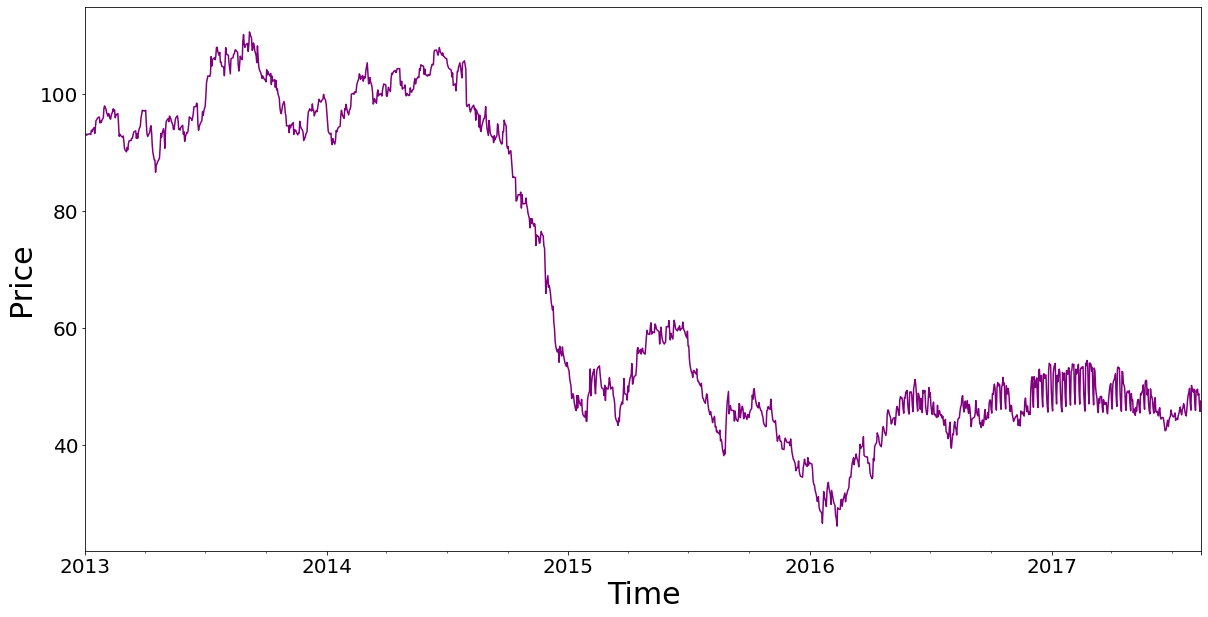

In [646]:
plt.figure(figsize=(20,10))
price_trend = oil_merged['oil_price'].copy()
price_trend.index = oil_merged['date'].copy()
price_trend.plot(fontsize=20,color='purple')
plt.xlabel('Time',fontsize=30)
plt.ylabel('Price',fontsize=30)
plt.show()

The highest oil prices were recorded in late 2013. However in 2014, the oil prices fell drastically by almost 50%. In late 2015 to early 2016, the oil prices plumetted further. But after that the oil prices slowly recovered and since mid 2016, the oil prices have been relatively steady.

## Items Dataset

In [220]:
len(items)

4100

In [222]:
items.shape

(4100, 4)

The items data set has four variables.

### Data types of each column

In [223]:
items.dtypes

item_nbr       int64
family        object
class          int64
perishable     int64
dtype: object

 `item_nbr` is a unique id for each item.<br>
 `family` is the category that an item belongs to.<br>
 `perishable` is a binary variable where 1 indicates item is perishable. <br>
 Unsure what `class` means, possibly a more granular view of the `family` variable as class seems to have a large number of sub-levels for each category in `family`. 

In [258]:
category = items['family'].unique()
len(category)

33

In [259]:
len(items['class'].unique())

337

There are 33 categories or families of items and 337 classes of items.

In [226]:
items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [127]:
items.tail()

,item_nbr,family,class,perishable
4095,2132318,GROCERY I,1002,0
4096,2132945,GROCERY I,1026,0
4097,2132957,GROCERY I,1068,0
4098,2134058,BEVERAGES,1124,0
4099,2134244,"LIQUOR,WINE,BEER",1364,0


In [128]:
items.describe()

,item_nbr,class,perishable
count,4.100000e+03,4100.0000,4100.000000
mean,1.251436e+06,2169.6500,0.240488
std,5.876872e+05,1484.9109,0.427432
min,9.699500e+04,1002.0000,0.000000
25%,8.181108e+05,1068.0000,0.000000
50%,1.306198e+06,2004.0000,0.000000
75%,1.904918e+06,2990.5000,0.000000
max,2.134244e+06,7780.0000,1.000000


In [129]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4100 entries, 0 to 4099
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   item_nbr    4100 non-null   int64 
 1   family      4100 non-null   object
 2   class       4100 non-null   int64 
 3   perishable  4100 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 128.2+ KB


### Check for null values

In [225]:
#check for which columns have null values. 
null_col = items.columns[items.isnull().any()]
#total number of null values in each column
items[null_col].isnull().sum()

Series([], dtype: float64)

No null values in items data

### Frequency of each category

In [236]:
items['family'].value_counts()

GROCERY I                     1334
BEVERAGES                      613
CLEANING                       446
PRODUCE                        306
DAIRY                          242
PERSONAL CARE                  153
BREAD/BAKERY                   134
HOME CARE                      108
DELI                            91
MEATS                           84
HOME AND KITCHEN I              77
LIQUOR,WINE,BEER                73
FROZEN FOODS                    55
POULTRY                         54
HOME AND KITCHEN II             45
EGGS                            41
CELEBRATION                     31
PREPARED FOODS                  26
LAWN AND GARDEN                 26
LADIESWEAR                      21
LINGERIE                        20
AUTOMOTIVE                      20
BEAUTY                          19
PLAYERS AND ELECTRONICS         17
SCHOOL AND OFFICE SUPPLIES      15
GROCERY II                      14
PET SUPPLIES                    14
SEAFOOD                          8
MAGAZINES           

`GROCERY I` has the highest number of products. However it is unclear what the difference between `GROCERY I` and `GROCERY II` is. The next most commonly seen items are `BEVERAGES`.  

#### Visualizing different categories in family as a count plot


Text(0, 0.5, 'Count')

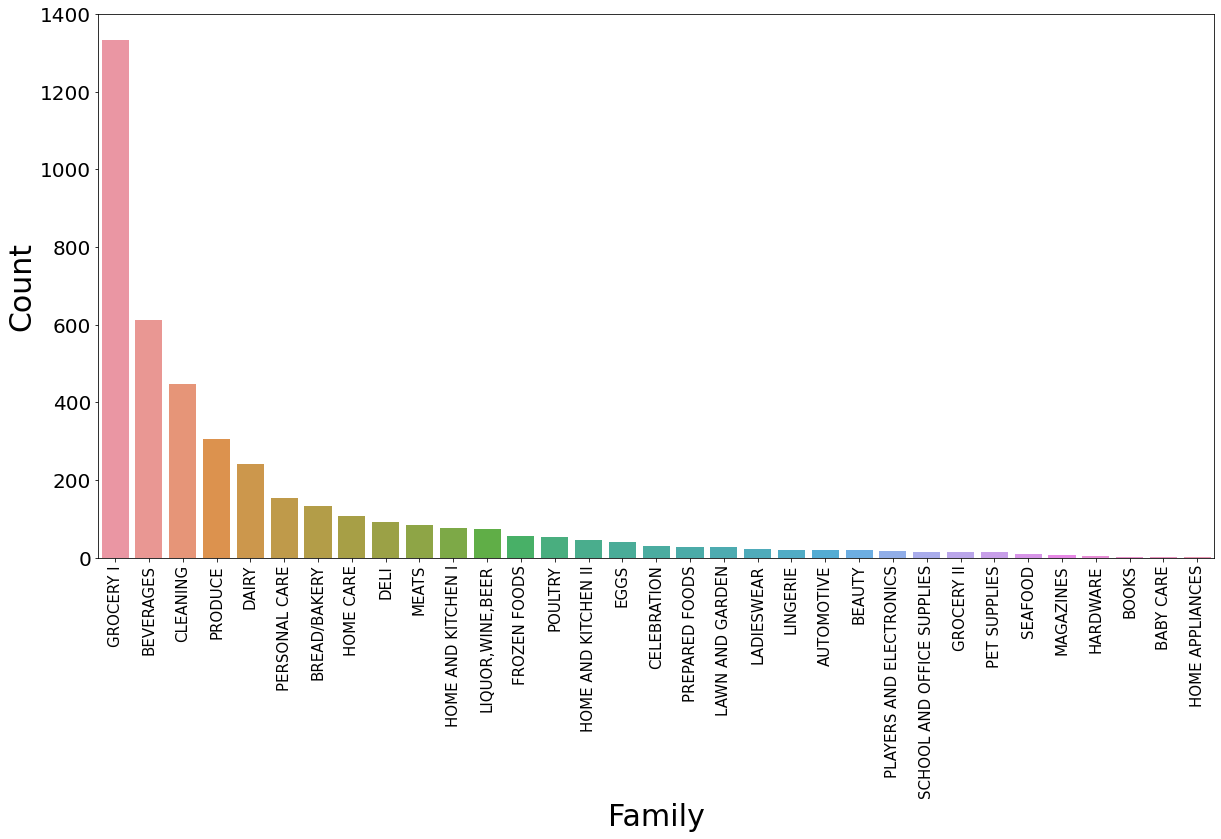

In [495]:
fig, ax = plt.subplots(figsize=(20,10))
sns.countplot(x='family',data=items,ax=ax, order=items['family'].value_counts().index)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90, fontsize=15)
plt.yticks(fontsize=20)
plt.xlabel('Family',fontsize=30)
plt.ylabel('Count',fontsize=30)

In [280]:
items['family'].value_counts().index

Index(['GROCERY I', 'BEVERAGES', 'CLEANING', 'PRODUCE', 'DAIRY',
       'PERSONAL CARE', 'BREAD/BAKERY', 'HOME CARE', 'DELI', 'MEATS',
       'HOME AND KITCHEN I', 'LIQUOR,WINE,BEER', 'FROZEN FOODS', 'POULTRY',
       'HOME AND KITCHEN II', 'EGGS', 'CELEBRATION', 'PREPARED FOODS',
       'LAWN AND GARDEN', 'LADIESWEAR', 'LINGERIE', 'AUTOMOTIVE', 'BEAUTY',
       'PLAYERS AND ELECTRONICS', 'SCHOOL AND OFFICE SUPPLIES', 'GROCERY II',
       'PET SUPPLIES', 'SEAFOOD', 'MAGAZINES', 'HARDWARE', 'BOOKS',
       'BABY CARE', 'HOME APPLIANCES'],
      dtype='object')

### Frequency of each class

In [344]:
class_freq = items['class'].value_counts()
class_freq


1016    133
1040    110
1124    100
1034     98
1122     81
       ... 
2103      1
4140      1
1153      1
1089      1
6241      1
Name: class, Length: 337, dtype: int64

In [350]:
len(class_freq[class_freq<=5])

180

There 180 classes that have less than 5 items in each of them

#### Get the 5 most commonly occuring classes 

In [341]:
freq_index = items['class'].value_counts().index
top5class_index = freq_index[:5]

Text(0, 0.5, 'Count')

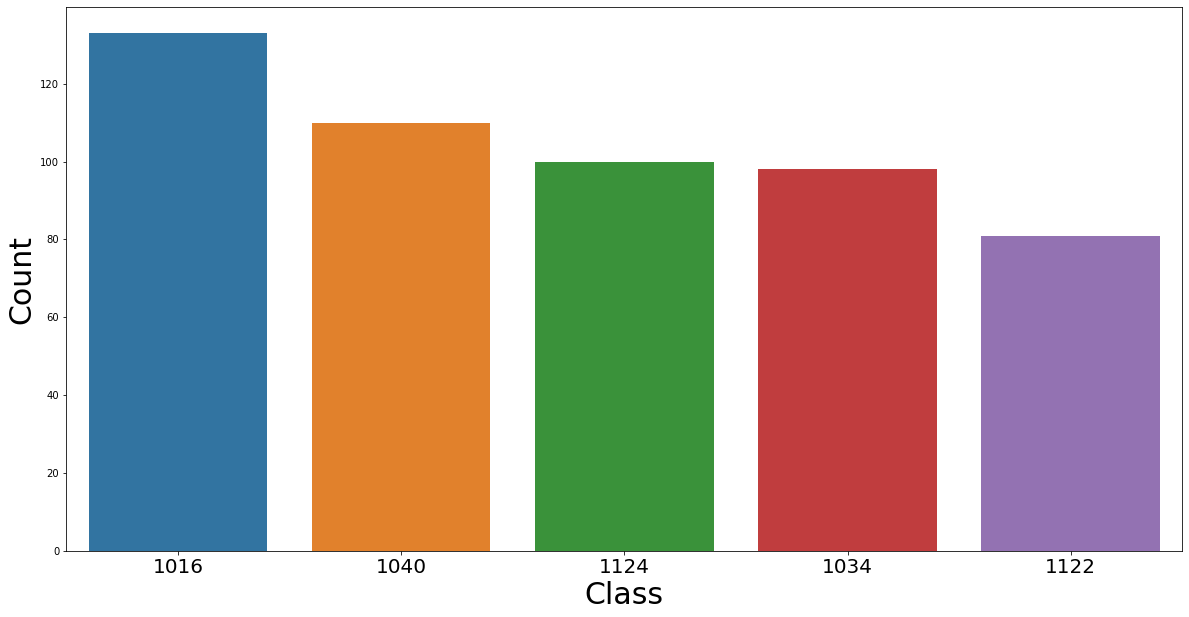

In [496]:
fig, ax = plt.subplots(figsize=(20,10))
sns.countplot(x='class',data=items,ax=ax, order=top5class_index)
plt.setp(ax.xaxis.get_majorticklabels(), fontsize=20)
plt.xlabel('Class',fontsize=30)
plt.ylabel('Count',fontsize=30)

The first two classes (1016 and 1040) with the highest number of items belong to the GROCERY I family (visualized below). The third highest occuring class is 1124 and belongs to the BEVERAGES family.

### Categorization of classes based on family

In [389]:
fig = px.treemap(items, path=['family', 'class'])
fig.show()

The above treemap shows the different classes of items in each family. This indicates that classes are a subdivision of family, thus it provides more specific categorization of items. Further each class has items from only one family.

### Proportion of perishables

#### Visualization showing the counts for whether item is perishable or not

Text(0, 0.5, 'Count')

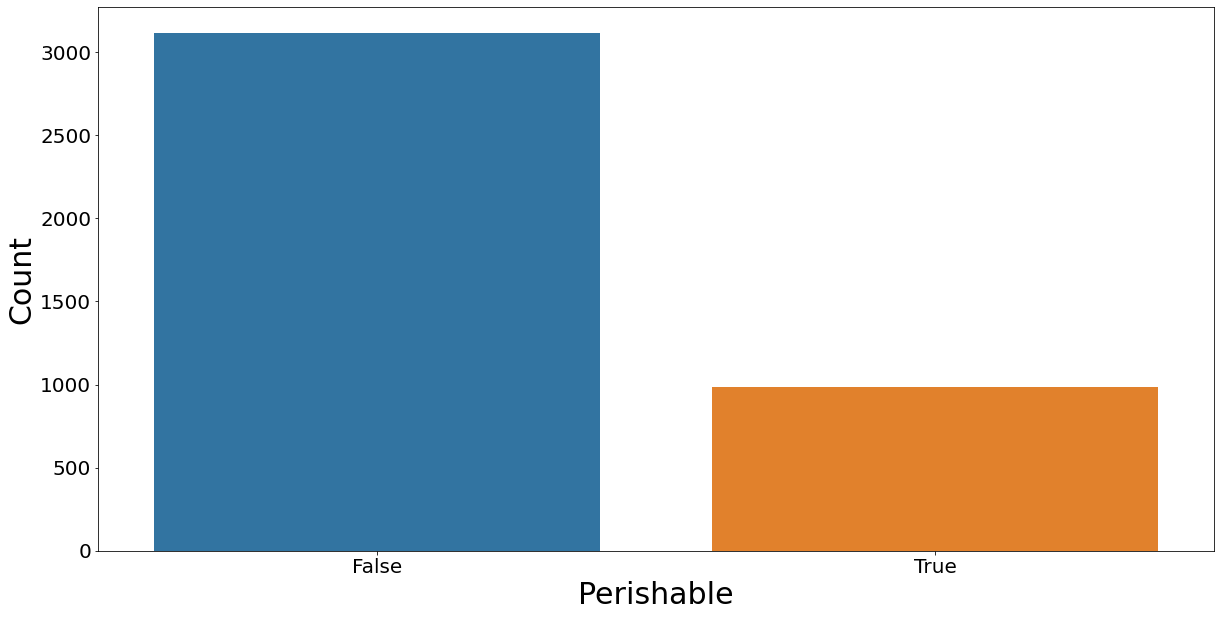

In [648]:
fig, ax = plt.subplots(figsize=(20,10))
sns.countplot(x='perishable', data=items,ax=ax)
ax.xaxis.set_ticklabels(['False','True'], fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Perishable', fontsize=30)
plt.ylabel('Count', fontsize=30)

In [444]:
perishable_family = items.groupby('family')['perishable'].sum() 
perishable_family[perishable_family>0]

family
BREAD/BAKERY      134
DAIRY             242
DELI               91
EGGS               41
MEATS              84
POULTRY            54
PREPARED FOODS     26
PRODUCE           306
SEAFOOD             8
Name: perishable, dtype: int64

About a quarter of the total items are perishable goods. As expected, most of these items are food related with PRODUCE having the largest number of perishable goods. This is closely followed by DAIRY and BAKERY products.

#### Treemap showing the categorization of perishables

In [647]:
fig = px.treemap(items, path=['perishable', 'family'])
fig.show()

The above treemap shows the families that are classified as perishable(1) and the families that are classified as non-perishable(0). As expected, most fresh food like produce, dairy and meats are classified as perishable due to their low shelf life. 

## Holidays Dataset

In [48]:
len(holidays)

350

In [545]:
holidays.shape

(350, 6)

In [429]:
holidays.dtypes

date           object
type           object
locale         object
locale_name    object
description    object
transferred      bool
dtype: object

In [508]:
holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


The dataset has no null values in any of the columns.

In [432]:
holidays.type.value_counts()

Holiday       221
Event          56
Additional     51
Transfer       12
Work Day        5
Bridge          5
Name: type, dtype: int64

In [549]:
holidays.locale.value_counts()

National    174
Local       152
Regional     24
Name: locale, dtype: int64

In [551]:
holidays.locale_name.value_counts()

Ecuador                           174
Quito                              13
Ambato                             12
Riobamba                           12
Latacunga                          12
Guaranda                           12
Guayaquil                          11
Ibarra                              7
Cuenca                              7
Esmeraldas                          6
Puyo                                6
Manta                               6
Cayambe                             6
Santa Elena                         6
Cotopaxi                            6
Santo Domingo                       6
Imbabura                            6
Santo Domingo de los Tsachilas      6
Quevedo                             6
El Carmen                           6
Libertad                            6
Salinas                             6
Loja                                6
Machala                             6
Name: locale_name, dtype: int64

The dataset has 6 variables:<br>
`date` : specifies when the holiday is celebrated.<br>
`type` : contains 6 different categories of the type of holidays.     <b>Holiday</b> refers to the date when the holiday avtually falls on. It is unclear what <b>Event</b> refers to (possibly local events sepcific to a particluar region, example a carnival or a parade. See section on total number of holidays for more details). <b>Transfers</b> refer to dates to which holidays were transferred from the weekend or another day.  <b>Additional</b> type represents the dates that fall close to holidays. So they are treated similar to holidays but they are not official holidays (like Christmas Eve or the day Christmas). <b>Bridge</b> days are the extra days added to a holiday to extend the break as a long weekend. <b>Work day</b> are days that are not normally scheduled for work (For example, Saturday and Sunday) but are used to make up for the Bridge days.<br>
`locale` refers to whether the holiday or events was on a national, regional or local scale. <br>
`locale_name` refers to city or region name where the holiday is celebrated or the event occurs.<br>
`description` gives the name of the holiday or event.<br>
`transferred` refers to whether a holiday or event was transferred to another day or not. 


### Frequency of holidays/ events based on type

Text(0, 0.5, 'Count')

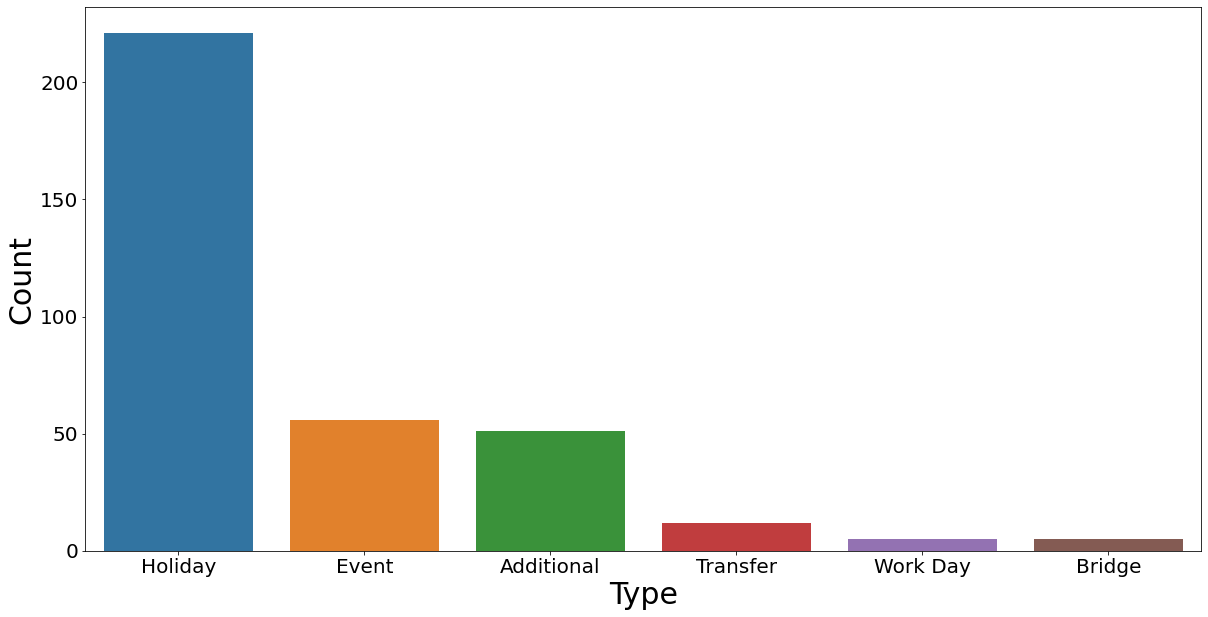

In [649]:
fig, ax = plt.subplots(figsize=(20,10))
sns.countplot(x='type',data=holidays,ax=ax, order=holidays.type.value_counts().index)
plt.setp(ax.xaxis.get_majorticklabels(), fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Type',fontsize=30)
plt.ylabel('Count',fontsize=30)

Holiday is the most commonly occuring type while Bridge and Work days are the least commonly occuring types. 

### Frequency of holidays/events based on locale categorization

Text(0, 0.5, 'Count')

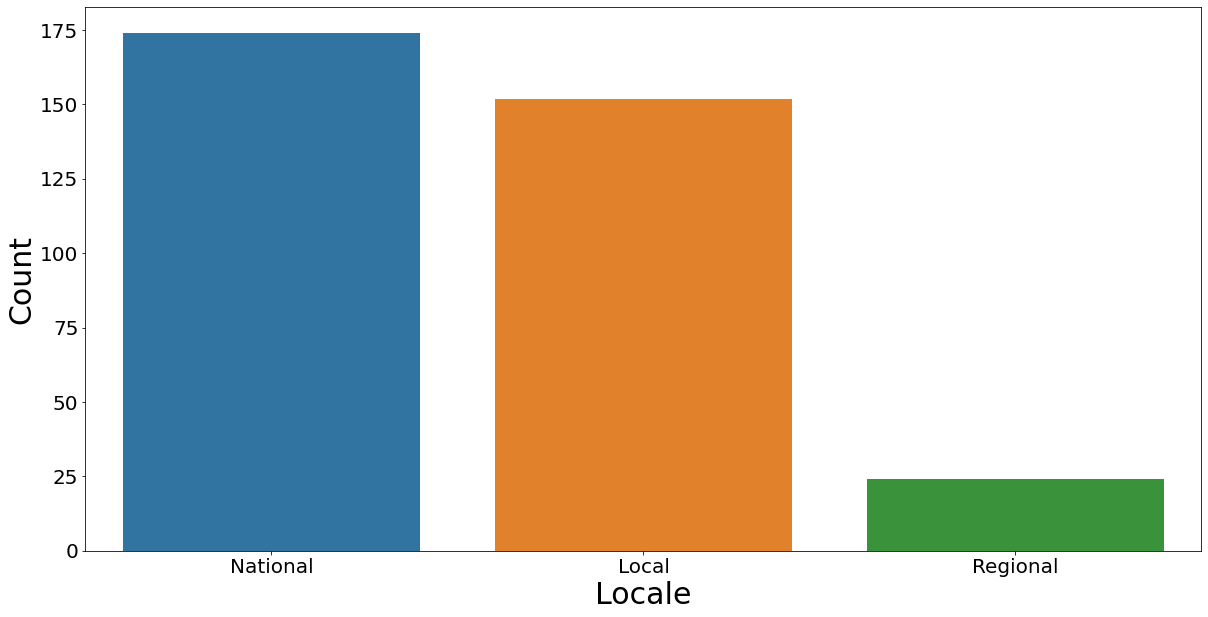

In [650]:
fig, ax = plt.subplots(figsize=(20,10))
sns.countplot(x='locale',data=holidays,ax=ax, order=holidays.locale.value_counts().index)
plt.setp(ax.xaxis.get_majorticklabels(), fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Locale',fontsize=30)
plt.ylabel('Count',fontsize=30)

Most of the events or holidays happen all over the country. There are very few regional holidays or events. 

### Frequency of holidays/events based on cities or regions

Text(0, 0.5, 'Count')

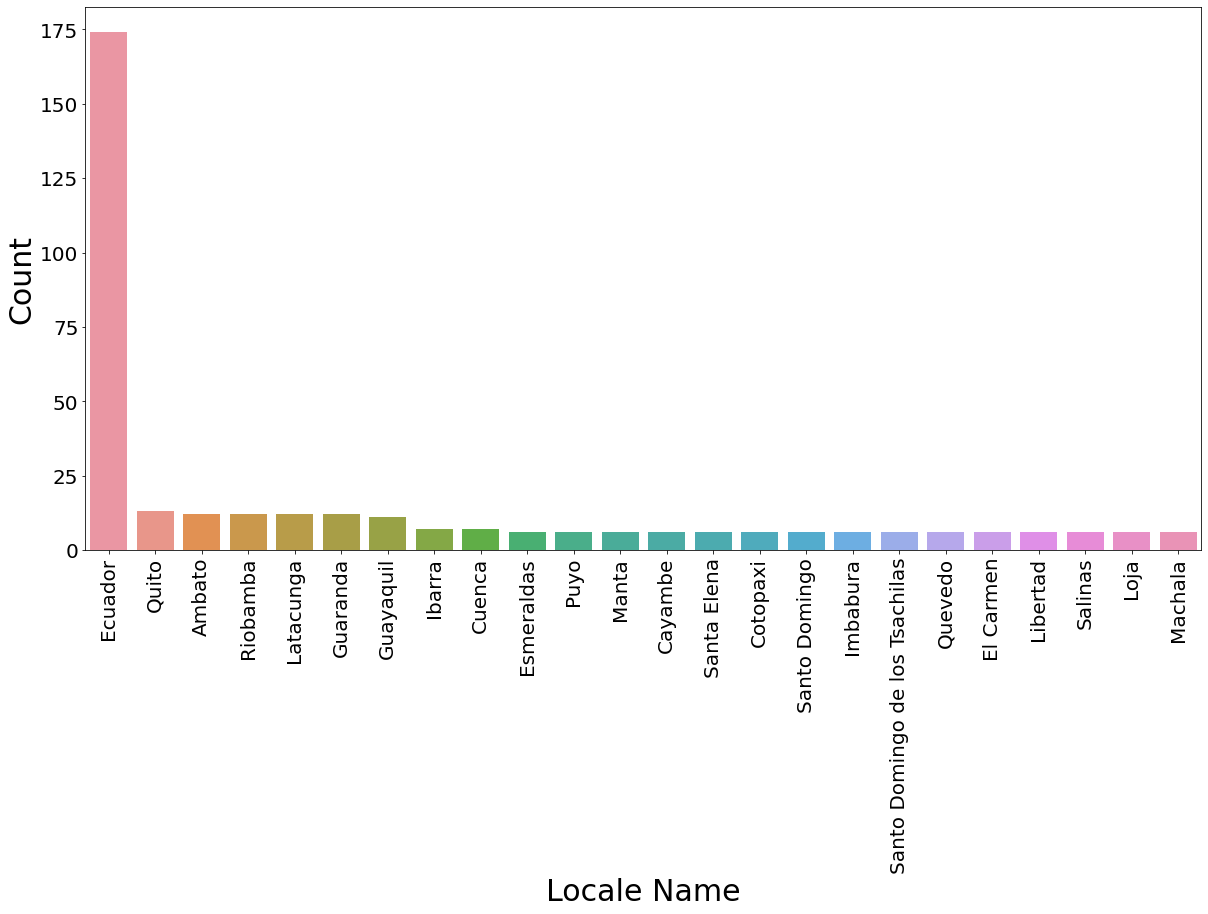

In [651]:
fig, ax = plt.subplots(figsize=(20,10))
sns.countplot(x='locale_name',data=holidays,ax=ax, order=holidays.locale_name.value_counts().index)
plt.setp(ax.xaxis.get_majorticklabels(), fontsize=20, rotation=90)
plt.yticks(fontsize=20)
plt.xlabel('Locale Name',fontsize=30)
plt.ylabel('Count',fontsize=30)

Since most holidays/ events are celebrated by the whole country, most holidays have the location as Ecuador. The rest of the holidays are celebrated in the major cities like Quito.

### Treemap showing the categorization of different cities/ regions based on  locale of holiday

In [560]:
fig = px.treemap(holidays, path=['locale', 'locale_name'])
fig.show()

### Visualization showing whether holiday is tranferred or not.

Text(0, 0.5, 'Count')

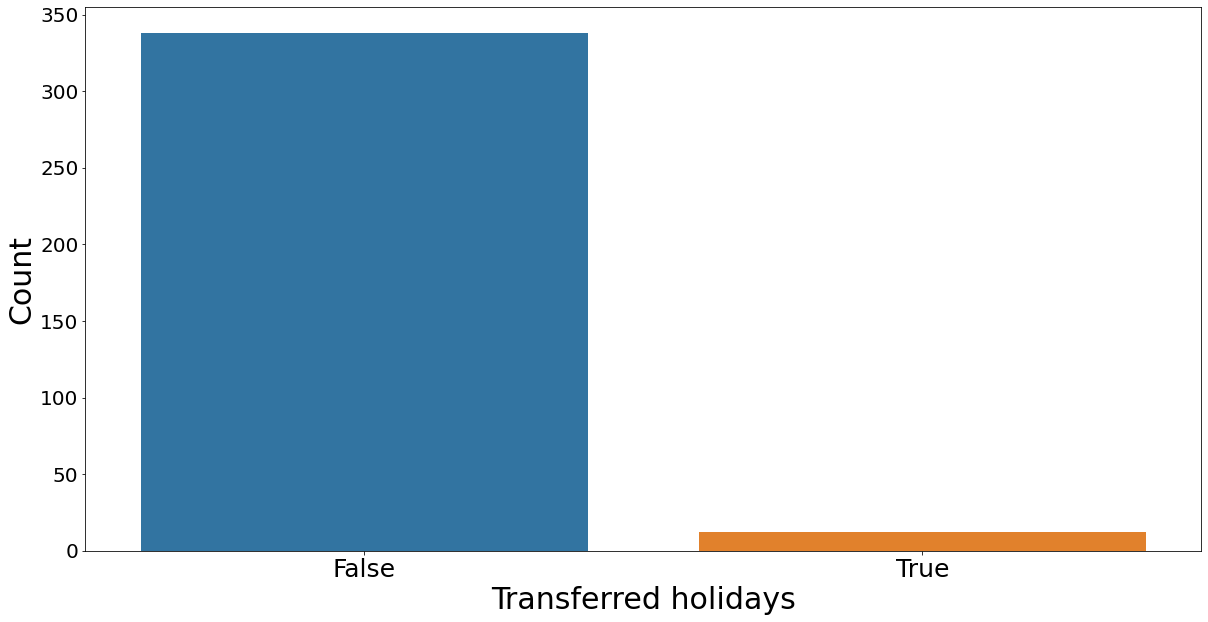

In [585]:
fig, ax = plt.subplots(figsize=(20,10))
sns.countplot(x='transferred',data=holidays,ax=ax)
plt.setp(ax.xaxis.get_majorticklabels(), fontsize=25)
plt.yticks(fontsize=20)
plt.xlabel('Transferred holidays',fontsize=30)
plt.ylabel('Count',fontsize=30)

As expected, majority of the holidays are not transferred and are celebrated on the same date the holiday actually falls on.

In [589]:
holidays[holidays['transferred']==True]

,date,type,locale,locale_name,description,transferred
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
72,2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
135,2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
255,2016-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
266,2016-07-25,Holiday,Local,Guayaquil,Fundacion de Guayaquil,True
268,2016-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True
297,2017-01-01,Holiday,National,Ecuador,Primer dia del ano,True
303,2017-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,True
312,2017-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
324,2017-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True


In [597]:
holidays.groupby(['type','transferred']).count()['date']

type        transferred
Additional  False           51
Bridge      False            5
Event       False           56
Holiday     False          209
            True            12
Transfer    False           12
Work Day    False            5
Name: date, dtype: int64

`transferred` = True indicates that the holiday was transferred to another day. So the dates where `transferred` = TRUE are actually working days. `type`= Transfer and `transferred` = False indicates that the date is a non-working day to which the holiday was transferred.

### Convert `date` from string type to datetime

In [598]:
holidays_cleaned = holidays

In [599]:
holidays_cleaned['date'] = pd.to_datetime(holidays_cleaned['date'], format='%Y-%m-%d')

#### Number of holidays in each year

In [617]:
year = pd.DatetimeIndex(holidays_cleaned['date']).year
year.value_counts()

2016    86
2014    67
2017    53
2015    52
2013    51
2012    41
Name: date, dtype: int64

#### Visualization of number of holidays in each year

Text(0, 0.5, 'Number of holidays')

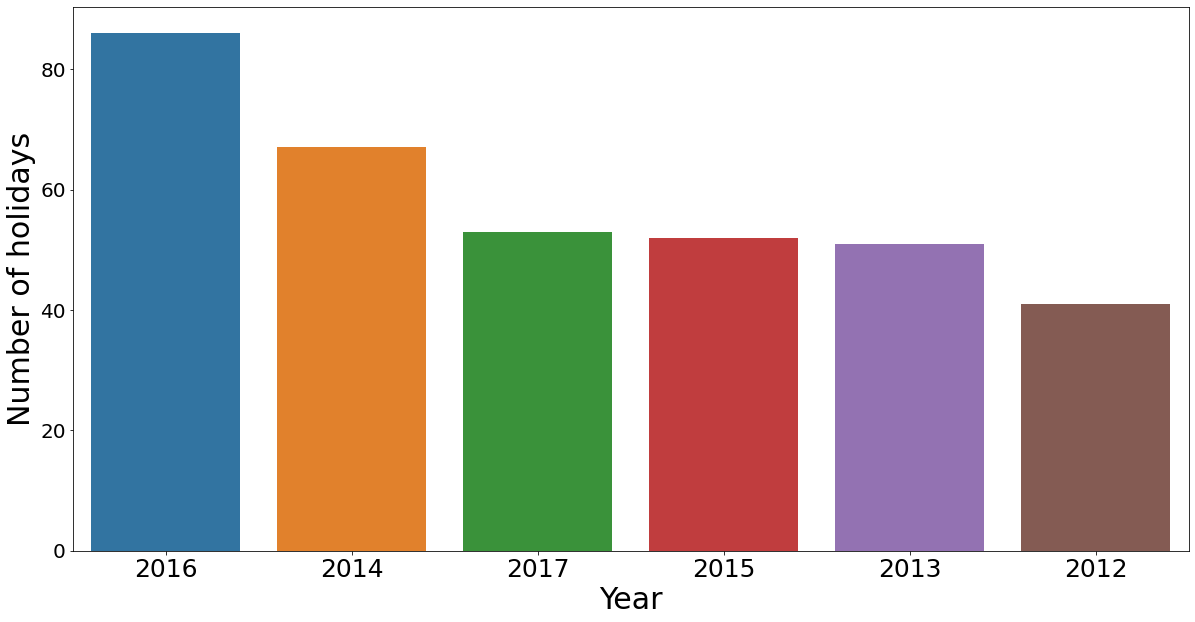

In [618]:
fig, ax = plt.subplots(figsize=(20,10))
sns.countplot(x=year,order=year.value_counts().index,ax=ax)
plt.setp(ax.xaxis.get_majorticklabels(), fontsize=25)
plt.yticks(fontsize=20)
plt.xlabel('Year',fontsize=30)
plt.ylabel('Number of holidays',fontsize=30)

We see that the years 2016 and 2014 have the largest number of holidays and events. So let's take a closer look at these years:

In [634]:
holiday_2014_2016 =holidays_cleaned[year==2014]
holiday_2014_2016['description'].unique()

array(['Primer dia del ano', 'Fundacion de Manta', 'Carnaval',
       'Provincializacion de Cotopaxi', 'Fundacion de Cuenca',
       'Cantonizacion de Libertad', 'Viernes Santo',
       'Cantonizacion de Riobamba', 'Dia del Trabajo',
       'Dia de la Madre-1', 'Dia de la Madre', 'Cantonizacion del Puyo',
       'Batalla de Pichincha', 'Inauguracion Mundial de futbol Brasil',
       'Mundial de futbol Brasil: Ecuador-Suiza',
       'Mundial de futbol Brasil: Ecuador-Honduras',
       'Cantonizacion de Guaranda', 'Cantonizacion de Latacunga',
       'Fundacion de Machala', 'Provincializacion de Imbabura',
       'Mundial de futbol Brasil: Ecuador-Francia',
       'Mundial de futbol Brasil: Octavos de Final',
       'Cantonizacion de El Carmen', 'Fundacion de Santo Domingo',
       'Mundial de futbol Brasil: Cuartos de Final',
       'Mundial de futbol Brasil: Semifinales',
       'Mundial de futbol Brasil: Tercer y cuarto lugar',
       'Mundial de futbol Brasil: Final', 'Cantonizacion 

In [637]:
holiday_2014_2016[holiday_2014_2016['description'].str.contains('futbol')]

,date,type,locale,locale_name,description,transferred
106,2014-06-12,Event,National,Ecuador,Inauguracion Mundial de futbol Brasil,False
107,2014-06-15,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Suiza,False
108,2014-06-20,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Honduras,False
113,2014-06-25,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Francia,False
114,2014-06-28,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False
115,2014-06-29,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False
116,2014-06-30,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False
117,2014-07-01,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False
120,2014-07-04,Event,National,Ecuador,Mundial de futbol Brasil: Cuartos de Final,False
121,2014-07-05,Event,National,Ecuador,Mundial de futbol Brasil: Cuartos de Final,False


We see that in 2014, the football worldcup event happened which contributed to the increased spike in the number of events and holidays. 

In [639]:
holiday_2014_2016 =holidays_cleaned[year==2016]
holiday_2014_2016['description'].unique()

array(['Primer dia del ano', 'Carnaval', 'Fundacion de Manta',
       'Viernes Santo', 'Provincializacion de Cotopaxi',
       'Fundacion de Cuenca', 'Cantonizacion de Libertad',
       'Terremoto Manabi', 'Terremoto Manabi+1', 'Terremoto Manabi+2',
       'Terremoto Manabi+3', 'Terremoto Manabi+4',
       'Cantonizacion de Riobamba', 'Terremoto Manabi+5',
       'Terremoto Manabi+6', 'Terremoto Manabi+7', 'Terremoto Manabi+8',
       'Terremoto Manabi+9', 'Terremoto Manabi+10', 'Terremoto Manabi+11',
       'Terremoto Manabi+12', 'Terremoto Manabi+13',
       'Terremoto Manabi+14', 'Dia del Trabajo', 'Terremoto Manabi+15',
       'Terremoto Manabi+16', 'Terremoto Manabi+17',
       'Terremoto Manabi+18', 'Terremoto Manabi+19',
       'Terremoto Manabi+20', 'Dia de la Madre-1', 'Terremoto Manabi+21',
       'Terremoto Manabi+22', 'Dia de la Madre', 'Terremoto Manabi+23',
       'Terremoto Manabi+24', 'Terremoto Manabi+25',
       'Cantonizacion del Puyo', 'Terremoto Manabi+26',
       

In [640]:
holiday_2014_2016[holiday_2014_2016['description'].str.contains('Terremoto')]

,date,type,locale,locale_name,description,transferred
219,2016-04-16,Event,National,Ecuador,Terremoto Manabi,False
220,2016-04-17,Event,National,Ecuador,Terremoto Manabi+1,False
221,2016-04-18,Event,National,Ecuador,Terremoto Manabi+2,False
222,2016-04-19,Event,National,Ecuador,Terremoto Manabi+3,False
223,2016-04-20,Event,National,Ecuador,Terremoto Manabi+4,False
225,2016-04-21,Event,National,Ecuador,Terremoto Manabi+5,False
226,2016-04-22,Event,National,Ecuador,Terremoto Manabi+6,False
227,2016-04-23,Event,National,Ecuador,Terremoto Manabi+7,False
228,2016-04-24,Event,National,Ecuador,Terremoto Manabi+8,False
229,2016-04-25,Event,National,Ecuador,Terremoto Manabi+9,False


The increase in 2016 events and holidays was due to the eathquake that occured on April 16th 2016. So the next 30 days after the earthquake are included as events in this data set.

## Stores Dataset

In [47]:
len(stores)

54

In [453]:
stores.shape

(54, 5)

In [454]:
stores.dtypes

store_nbr     int64
city         object
state        object
type         object
cluster       int64
dtype: object

`store_nbr` is a unique value to identify each store.<br>
`city` and `state` variables give the location for each store.<br>
It is unclear what `type` refers to.<br>
`cluster` represent clustering of similar stores based on certain characteristics. However, it in unclear on what basis these clusters have been made. 

In [459]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


There are no null values in this dataset.

In [455]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [477]:
stores.city.value_counts()

Quito            18
Guayaquil         8
Santo Domingo     3
Cuenca            3
Ambato            2
Latacunga         2
Machala           2
Manta             2
Libertad          1
Guaranda          1
Ibarra            1
Cayambe           1
Riobamba          1
Quevedo           1
Puyo              1
Loja              1
Salinas           1
Daule             1
Playas            1
Babahoyo          1
El Carmen         1
Esmeraldas        1
Name: city, dtype: int64

In [473]:
stores.state.value_counts()

Pichincha                         19
Guayas                            11
Manabi                             3
Azuay                              3
Santo Domingo de los Tsachilas     3
Tungurahua                         2
El Oro                             2
Los Rios                           2
Cotopaxi                           2
Imbabura                           1
Chimborazo                         1
Esmeraldas                         1
Santa Elena                        1
Loja                               1
Pastaza                            1
Bolivar                            1
Name: state, dtype: int64

In [471]:
len(stores.city.unique())

22

In [472]:
len(stores.state.unique())

16

In [476]:
stores.type.value_counts()

D    18
C    15
A     9
B     8
E     4
Name: type, dtype: int64

### Number of stores in each city

Text(0, 0.5, 'Count')

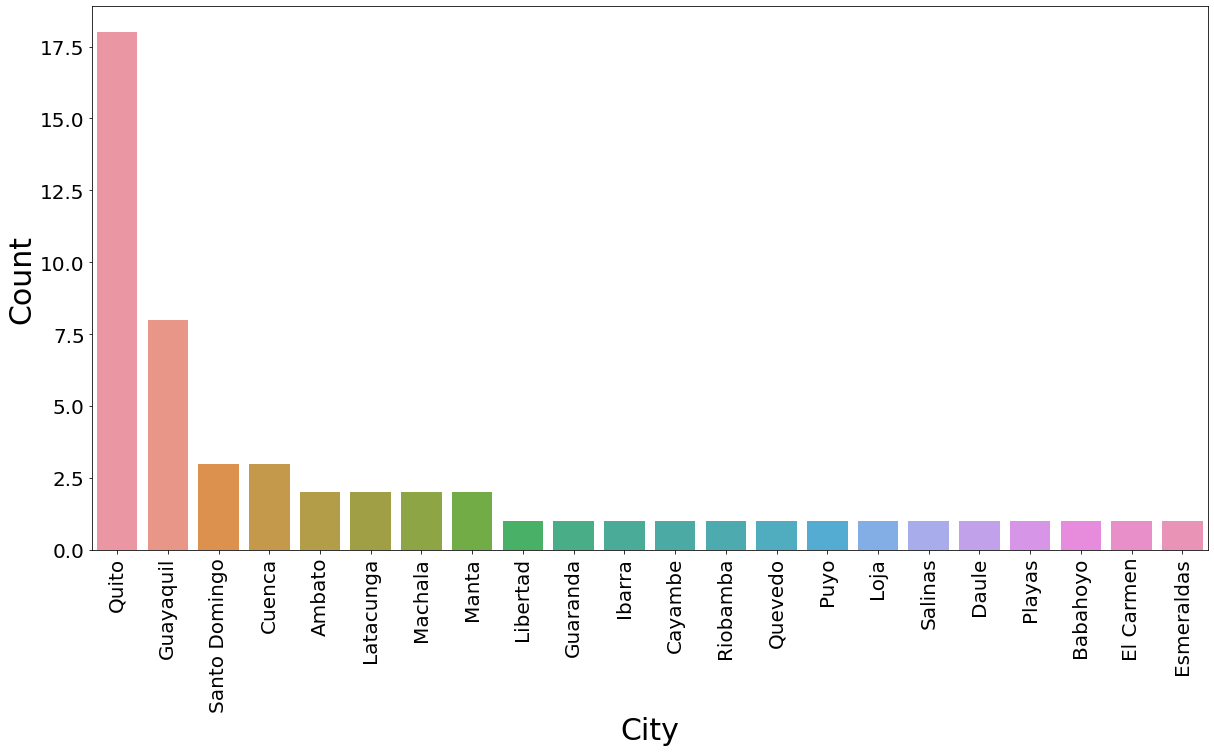

In [499]:
fig, ax = plt.subplots(figsize=(20,10))
sns.countplot(x='city',data=stores,ax=ax, order=stores['city'].value_counts().index)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90, fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('City',fontsize=30)
plt.ylabel('Count',fontsize=30)

### Distribution of stores across different states

Text(0, 0.5, 'Count')

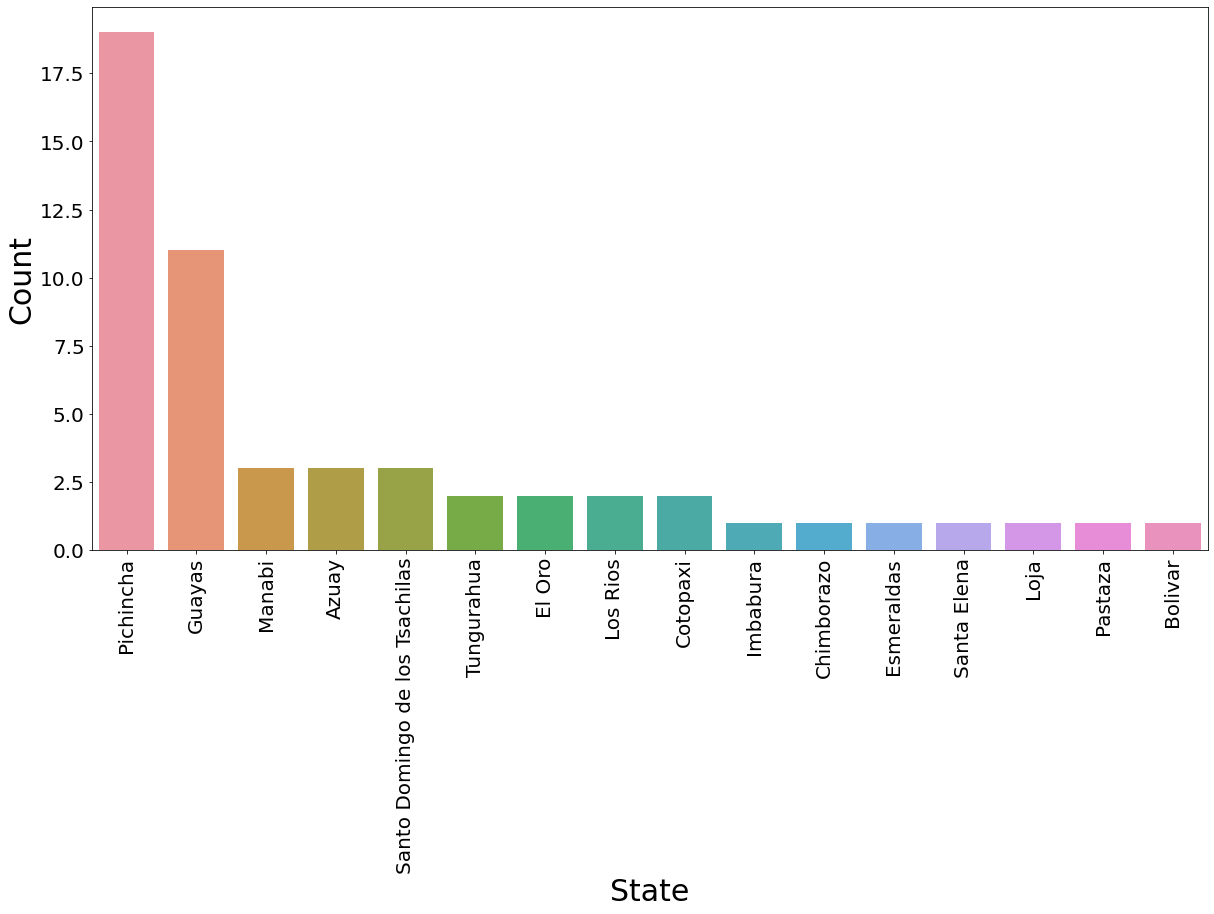

In [652]:
fig, ax = plt.subplots(figsize=(20,10))
sns.countplot(x='state',data=stores,ax=ax, order=stores['state'].value_counts().index)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90, fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('State',fontsize=30)
plt.ylabel('Count',fontsize=30)

### Categorization of stores based on their type

Text(0, 0.5, 'Count')

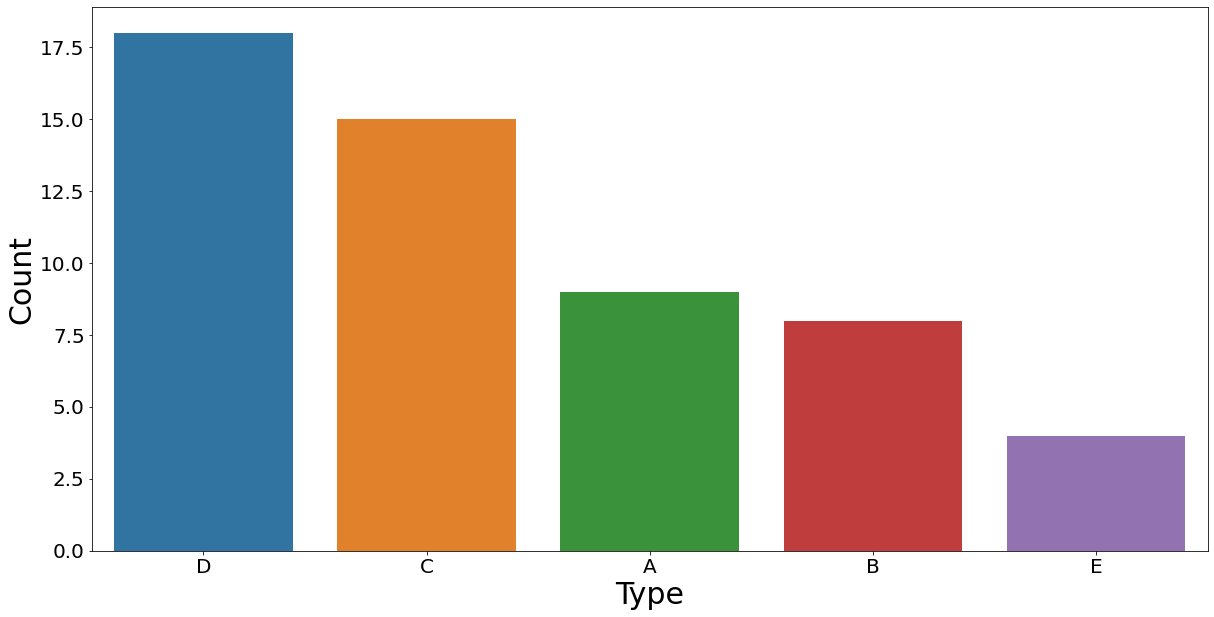

In [502]:
fig, ax = plt.subplots(figsize=(20,10))
sns.countplot(x='type',data=stores,ax=ax, order=stores['type'].value_counts().index)
plt.setp(ax.xaxis.get_majorticklabels(), fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Type',fontsize=30)
plt.ylabel('Count',fontsize=30)

### Number of stores in each cluster

Text(0, 0.5, 'Count')

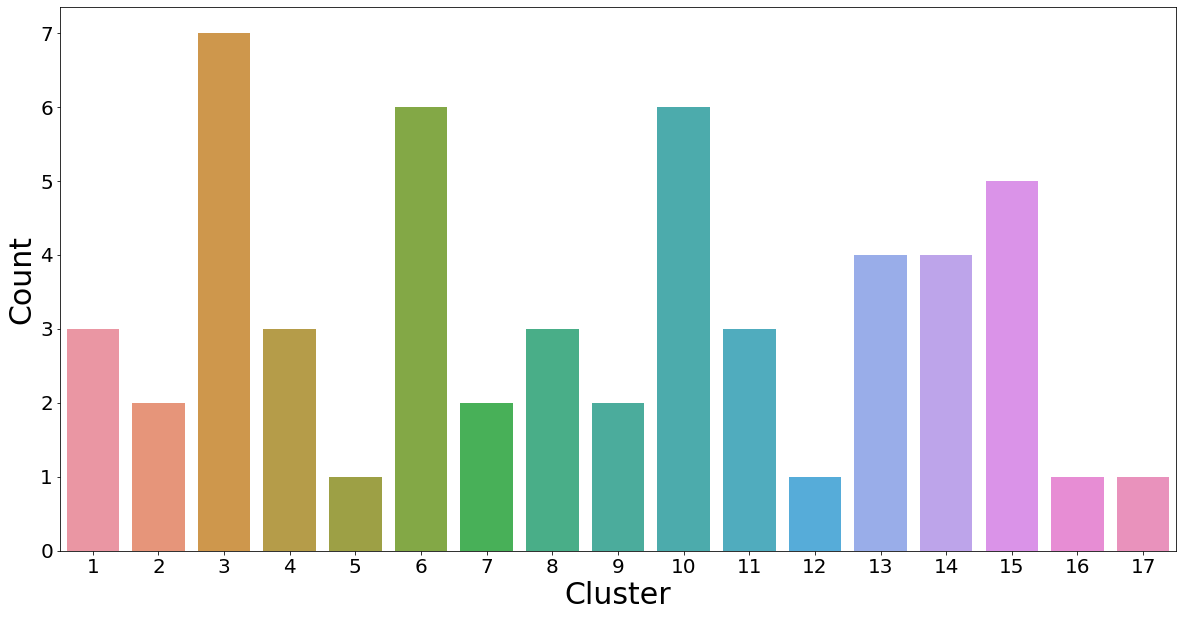

In [655]:
fig, ax = plt.subplots(figsize=(20,10))
sns.countplot(x='cluster',data=stores,ax=ax)
plt.setp(ax.xaxis.get_majorticklabels(), fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Cluster',fontsize=30)
plt.ylabel('Count',fontsize=30)

### Treemap showing the cities in each state that have stores

In [507]:
fig = px.treemap(stores, path=['state', 'city'])
fig.show()

Overall, there are stores in 22 cities and 16 states.<br>
Most of the stores are in Quito (in Pichincha), which has 18 stores, and Guayaquil (in Guayas), which has 8 stores. This is to be expected because these are the largest and most populated cities in Ecuador. Most of the stores are in Pichincha and Guayas states. Further, all states except Guayas and Pichincha have stores in only one city. Guayas has stores in 4 cities while Pichincha has stores in 2 cities.<br>
The most commonly seen types of stores are D and C, although it is unclear what these types mean. Similarly, it is difficult to determine what clusters mean whithout having complete information of the basis on which the clustering was done. From the EDA, we know the clusters range from 1 to 17. 